In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight

# 1. Induced Imbalance Function (Problem 2: Data-Level Technique)
def get_imbalanced_cifar10(dataset, imbalance_ratio=0.1):
    targets = np.array(dataset.targets)
    classes = np.unique(targets)
    img_max = len(targets) // len(classes)
    indices = []
    for i in range(len(classes)):
        # Create a decaying number of samples per class
        num_sample = int(img_max * (imbalance_ratio**(i / (len(classes) - 1.0))))
        idx = np.where(targets == i)[0][:num_sample]
        indices.extend(idx)
    return Subset(dataset, indices)

# Data Augmentation (Problem 2: Minority Class Support)
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load Datasets
full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
imbalanced_train_ds = get_imbalanced_cifar10(full_train, imbalance_ratio=0.05) # 20:1 ratio
train_loader = DataLoader(imbalanced_train_ds, batch_size=64, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f"Total imbalanced training samples: {len(imbalanced_train_ds)}")

Total imbalanced training samples: 17023


In [ ]:
# Custom CNN (Problem 1)
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(0.3), # Regularization
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        feat = x # Deep features for t-SNE
        x = self.classifier(x)
        return x, feat

# Comparative Model (Problem 3: ResNet18)
model_resnet = torchvision.models.resnet18(weights=None)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)

In [ ]:
# Calculate Class Weights (Algorithm-Level Technique)
y_train = [label for _, label in imbalanced_train_ds]
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

# Problem 4 Experiment: Weighted Cross Entropy
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.001) # AdamW for better weight decay

# Simple Training Loop
def train_model(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}")

train_model(model, train_loader, epochs=15)

Epoch 1, Loss: 1.8908
Epoch 2, Loss: 1.6679
Epoch 3, Loss: 1.5634
Epoch 4, Loss: 1.4885
Epoch 5, Loss: 1.4222
Epoch 6, Loss: 1.3738
Epoch 7, Loss: 1.3282
Epoch 8, Loss: 1.2955
Epoch 9, Loss: 1.2742
Epoch 10, Loss: 1.2420
Epoch 11, Loss: 1.2136
Epoch 12, Loss: 1.1826
Epoch 13, Loss: 1.1666
Epoch 14, Loss: 1.1378
Epoch 15, Loss: 1.1257



--- PERFORMANCE ANALYSIS ---
              precision    recall  f1-score   support

    airplane       0.65      0.64      0.64      1000
  automobile       0.76      0.67      0.71      1000
        bird       0.51      0.45      0.48      1000
         cat       0.44      0.32      0.37      1000
        deer       0.54      0.50      0.52      1000
         dog       0.39      0.74      0.51      1000
        frog       0.78      0.56      0.65      1000
       horse       0.71      0.57      0.63      1000
        ship       0.75      0.67      0.71      1000
       truck       0.61      0.76      0.68      1000

    accuracy                           0.59     10000
   macro avg       0.61      0.59      0.59     10000
weighted avg       0.61      0.59      0.59     10000

Balanced Accuracy: 0.5880


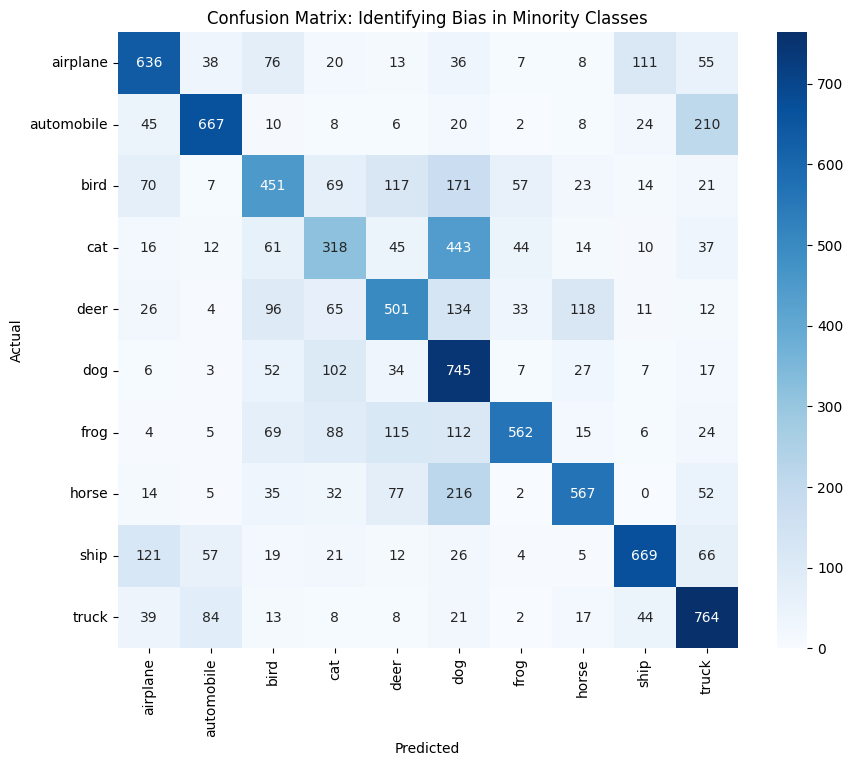


Generating t-SNE plot (this may take a minute)...


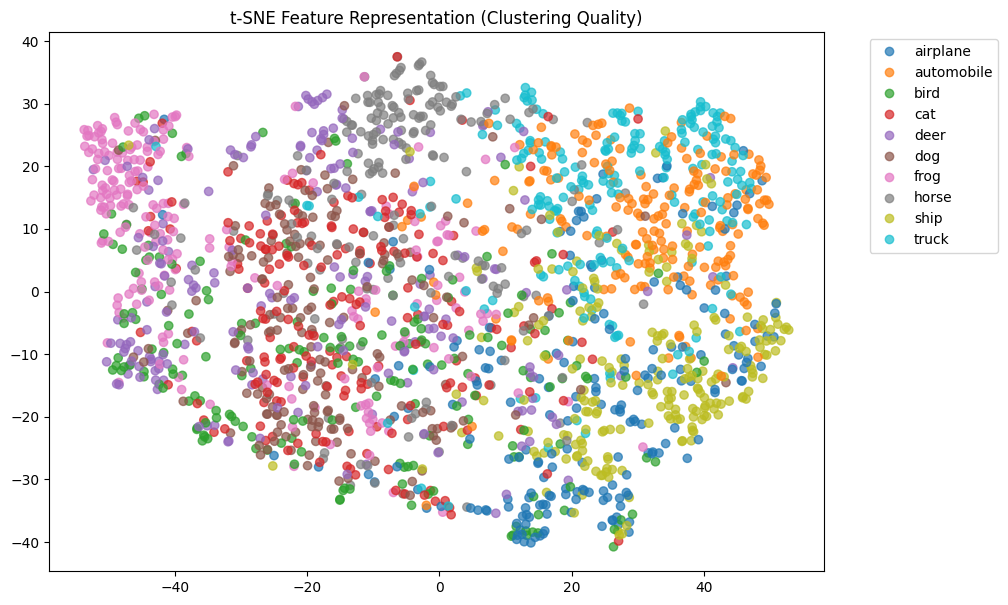

In [ ]:
def run_analysis(model, loader, classes):
    model.eval()
    all_preds, all_labels, all_feats = [], [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs, feats = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_feats.append(feats.cpu().numpy())

    all_feats = np.concatenate(all_feats)

    # 1. Detailed Metrics (Problem 3)
    print("\n--- PERFORMANCE ANALYSIS ---")
    print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))
    print(f"Balanced Accuracy: {balanced_accuracy_score(all_labels, all_preds):.4f}")

    # 2. Confusion Matrix (Problem 7: Error Analysis)
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title("Confusion Matrix: Identifying Bias in Minority Classes")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # 3. t-SNE (Problem 5: Feature Visualization)
    print("\nGenerating t-SNE plot (this may take a minute)...")
    tsne = TSNE(n_components=2, random_state=42)
    # Sampling 2000 points for speed
    feat_subset = all_feats[:2000]
    label_subset = np.array(all_labels)[:2000]
    tsne_results = tsne.fit_transform(feat_subset)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_subset, cmap='tab10', alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes, bbox_to_anchor=(1.05, 1))
    plt.title("t-SNE Feature Representation (Clustering Quality)")
    plt.show()

run_analysis(model, test_loader, class_names)